In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import yfinance as yf
import datetime

## Basics

1. Lithium Carbonate (wind database).csv

2. Lithium Hydroxide (wind database).csv

3. 99C-LTCB.csv (Lithium Carbonate (Li2CO3) 99% Min China Spot)
- File: 99C-LTCB.csv
- Source: Investing.com
- URL: https://www.investing.com/commodities/lithium-carbonate-99-min-china-futures-historical-data
- Currency: CNY
- Available times: since 2009-05-01

4. 99MIN-LTMT.csv (99% Min China Lithium Metal Spot)
- File: 99MIN-LTMT.csv
- Source: Investing.com
- URL: https://www.investing.com/commodities/99-min-china-lithium-metal-futures-historical-data
- Currency: CNY
- Available times: sincd 2015-10-01

In [2]:
def wind_process(df):
    df.set_index('Date', inplace = True)
    df.rename(columns = {df.columns[0]: 'Price'}, inplace = True)
    df.index = pd.to_datetime(df.index)
    df['Price'].replace(0, np.NaN, inplace = True)
    return df

def str_to_num(s):
    s = str(s).replace(',', '')
    return float(s)

def investing_process(df):
    df['Date'] = pd.to_datetime(df['Date'], format = '%m/%d/%Y')
    df.set_index('Date', inplace = True)
    df.sort_index(ascending=True, inplace = True)
    df['Price'] = df['Price'].apply(str_to_num)
    df['Price'].replace(0, np.NaN, inplace = True)
    return df

yn = {
    'li2co3': 'Lithium Carbonate (wind database)',
    'lioh': 'Lithium Hydroxide (wind database)',
    'ltcb': 'Lithium Carbonate 99% Min China Spot',
    'ltmt': '99% Min China Lithium Metal Spot'
}

## Zeros

For all of our lithium prices series, we are going to compute **monthly** and **annual** ZEROS series. 

- Compute log returns for every trading day (21/22 trading days per month)


In [3]:
y_all = {
    'li2co3': wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv')), # Wind Lithium Carbonate Price
    'lioh': wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv')), # Wind Lithium Hydroxide Price
    'ltcb': investing_process(pd.read_csv('./Data/99C-LTCB.csv', usecols=[0,1])), # Investing.com Lithium Carbonate (Li2CO3) 99% Min China Spot
    'ltmt': investing_process(pd.read_csv('./Data/99MIN-LTMT.csv', usecols=[0,1])) # Investing.com 99% Min China Lithium Metal Spot
}

def daily_log(df):
    df['Daily_return'] = np.log(df['Price']).diff()
    df['Daily_return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    return df

for df in y_all:
    y_all[df] = daily_log(y_all[df])
    # display(y_all[df])

- ZEROS(t) [where t is a month] is # zero returns in month t/#trading days in month t
- Graph the monthly zeros over time (all on one graph)

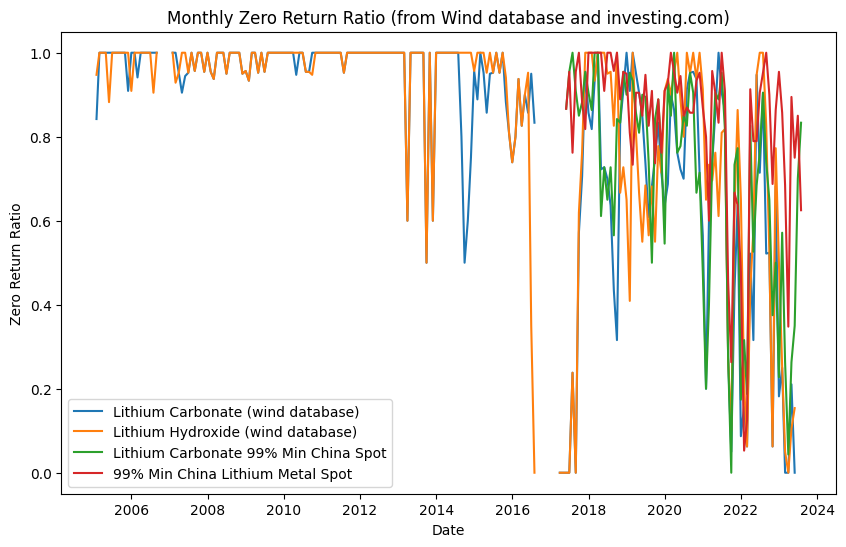

In [4]:
for df in y_all:
    y_all[df]['Zeros'] = (y_all[df]['Daily_return'] == 0).astype(int)

def zeros(df, freq): # freq: 'M' for monthly end, 'A' for yearly end
    z = df['Zeros'].resample(f'{freq}').sum() / df['Zeros'].resample(f'{freq}').size()
    return z.to_frame()

y_zeros_m = {df: zeros(y_all[df], 'M') for df in y_all}

fig_zeros_m = plt.figure(figsize = (10,6))
for df in y_zeros_m:
    plt.plot(y_zeros_m[df], label = yn[df])

plt.title('Monthly Zero Return Ratio (from Wind database and investing.com)')
plt.xlabel('Date')
plt.ylabel('Zero Return Ratio')
plt.legend(loc='best')
plt.show()

- Average per year and create a table for the 4 lithium series on how the annual zeros evolve. 

In [5]:
y_zeros_y = {df: zeros(y_all[df],'A') for df in y_all}

zeros_table = pd.DataFrame(index = y_zeros_y['li2co3'].index)
for df in y_zeros_y:
    zeros_table = pd.merge(zeros_table, y_zeros_y[df].loc[:,'Zeros'], how='left', left_index=True, right_index=True, suffixes=(None,f'_{df}'))
zeros_table.rename(columns = {'Zeros':'Zeros_li2co3'}, inplace=True)

display(zeros_table)


,Zeros_li2co3,Zeros_lioh,Zeros_ltcb,Zeros_ltmt
Date,,,,
2005-12-31,0.978632,0.978632,NaN,NaN
2006-12-31,0.993151,0.986301,NaN,NaN
2007-12-31,0.970711,0.979079,NaN,NaN
2008-12-31,0.979592,0.979592,NaN,NaN
2009-12-31,0.987654,0.987654,NaN,NaN
2010-12-31,0.987500,0.987500,NaN,NaN
2011-12-31,0.995902,0.995902,NaN,NaN
2012-12-31,1.000000,1.000000,NaN,NaN
2013-12-31,0.882353,0.882353,NaN,NaN


## Correlation And Autocorrelation

How do the different lithium price changes

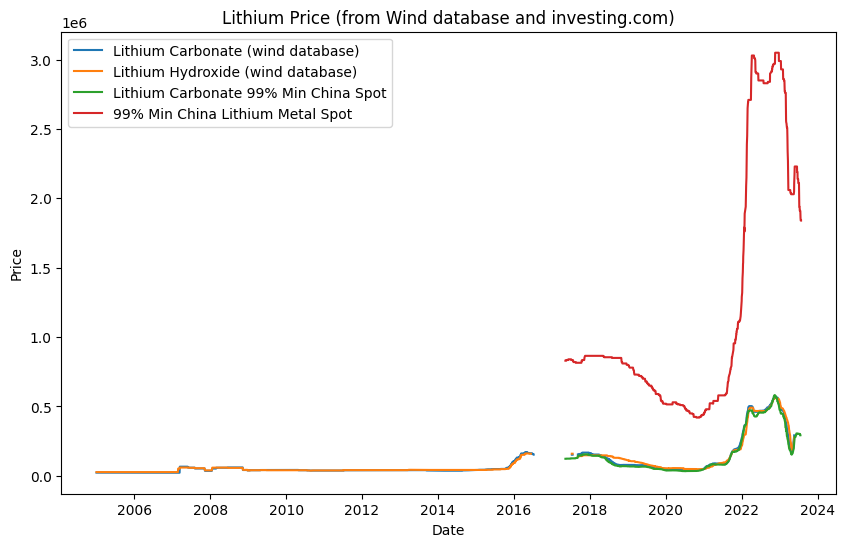

In [6]:
fig_price = plt.figure(figsize = (10,6))
for df in y_all:
    plt.plot(y_all[df].index,y_all[df]['Price'], label = yn[df])

plt.title('Lithium Price (from Wind database and investing.com)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

- Graph the 4 price series on one graph over the common period, renormalize to start at same point
- ~~Weekly change (Friday to Friday)~~

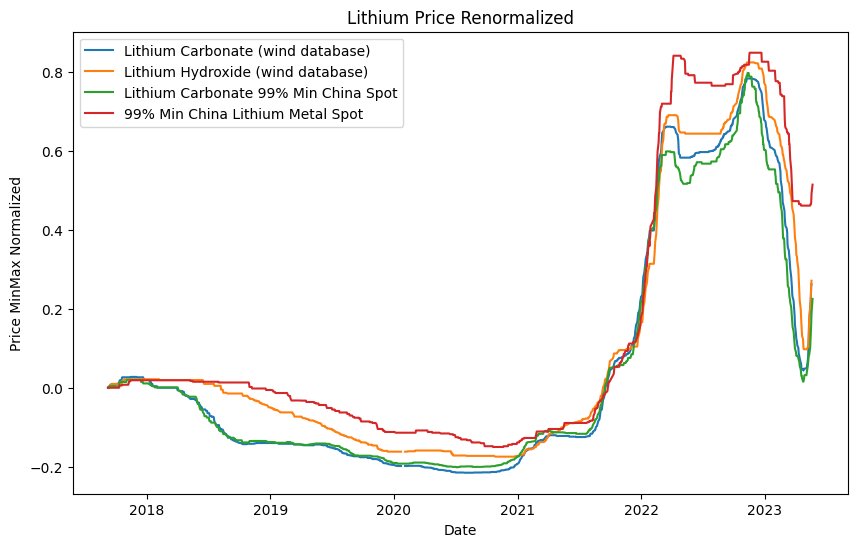

,Weekly_return_li2co3,Weekly_return_lioh,Weekly_return_ltcb,Weekly_return_ltmt
Date,,,,
2017-09-08,NaN,NaN,NaN,NaN
2017-09-11,NaN,NaN,NaN,NaN
2017-09-12,NaN,NaN,NaN,NaN
2017-09-13,NaN,NaN,NaN,NaN
2017-09-14,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-05-16,0.304169,0.257947,0.154549,0.004914
2023-05-17,0.273189,0.276077,0.173703,0.004914
2023-05-18,0.253781,0.267700,0.204501,0.009804


<Axes: title={'center': 'ltmt 2017 Partial Autocorrelation'}>

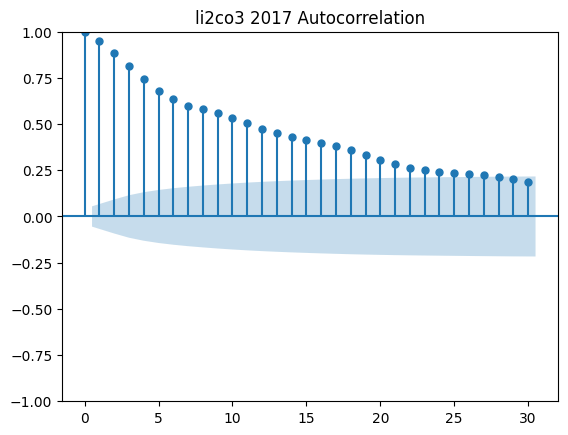

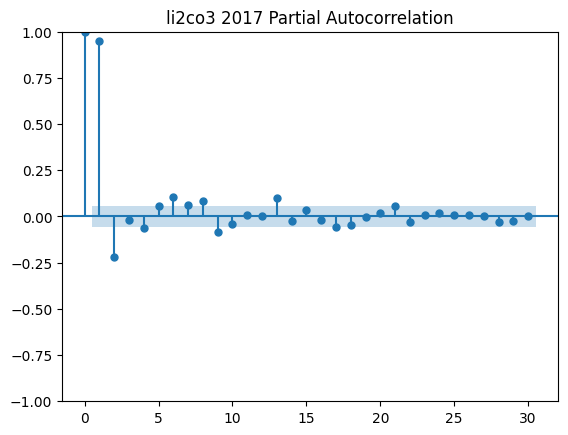

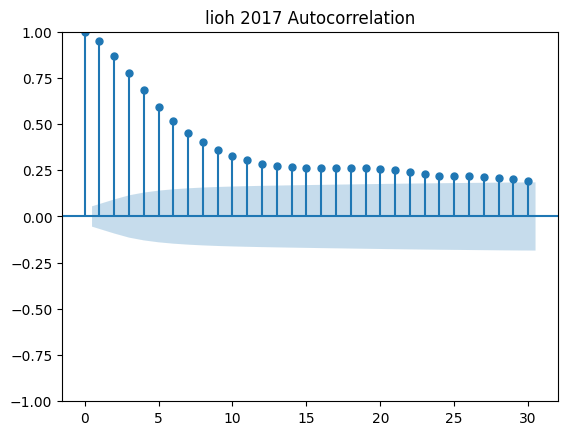

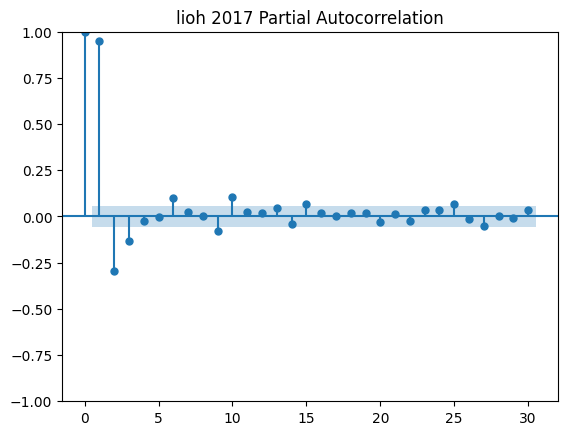

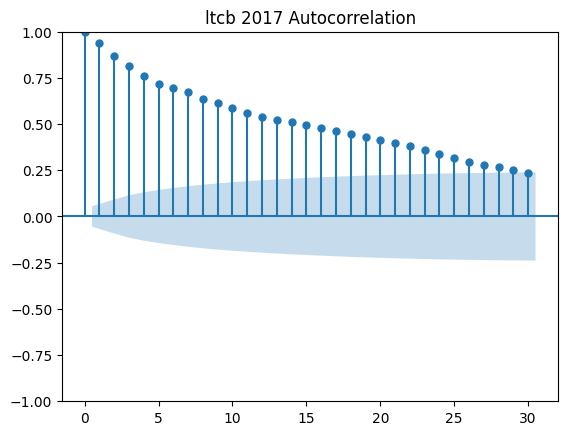

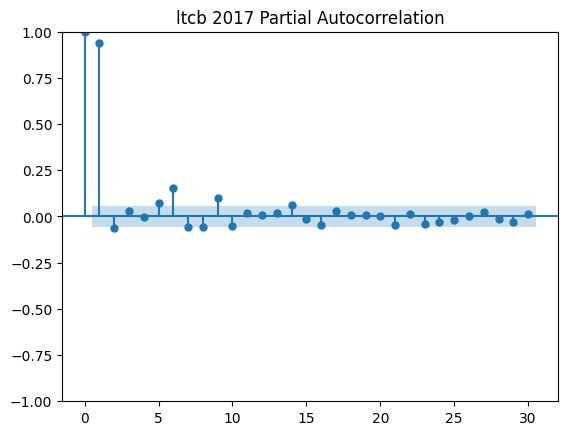

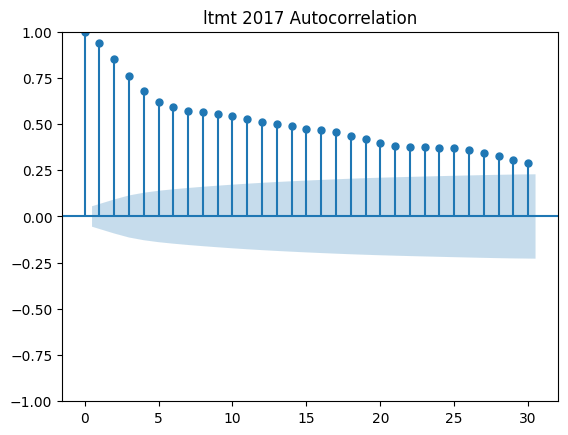

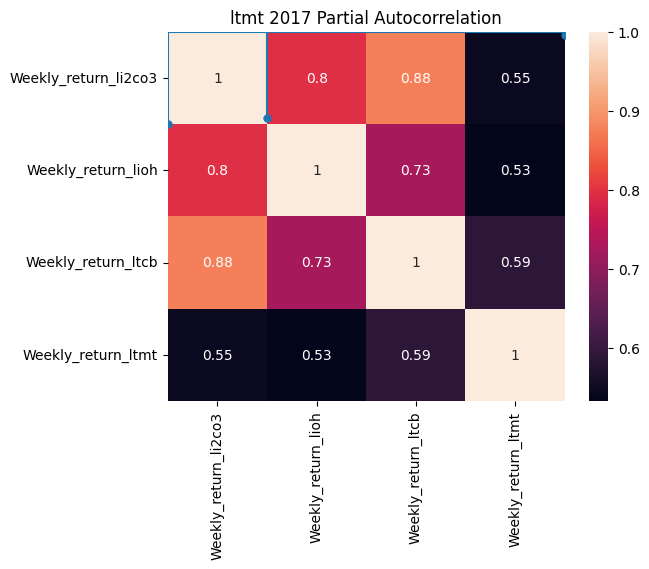

In [7]:
# Start date 2017-09-08
# Start date 2021-01-01
# The following are weekly return FOR EACH DAY
# which means return for Thu is calculated with Thu last week
def set_period(df, start_date):
    return df[df.index.isin(pd.date_range(start_date, '2023-05-22'))]

y_2017 = {
    'li2co3': set_period(wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv')),'2017-09-08'), 
    'lioh': set_period(wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv')),'2017-09-08'), 
    'ltcb': set_period(investing_process(pd.read_csv('./Data/99C-LTCB.csv', usecols=[0,1])),'2017-09-08'), 
    'ltmt': set_period(investing_process(pd.read_csv('./Data/99MIN-LTMT.csv', usecols=[0,1])),'2017-09-08')
}

def normalize(df): # Min Max Normalize
    df['Price_normalized'] = (df['Price'] - df['Price'].min())/(df['Price'].max() - df['Price'].min())
    
    first = df['Price_normalized'].iloc[0]
    df['Price_normalized'] = df['Price_normalized'] - first # start from same point
    return df

y_2017_normalized = {df: normalize(set_period(y_2017[df],'2017-09-08')) for df in y_2017}

fig_price_normalized = plt.figure(figsize = (10,6))
for df in y_2017_normalized:
    # display(y_2017[df])
    plt.plot(y_2017_normalized[df]['Price_normalized'], label = yn[df])

plt.title('Lithium Price Renormalized')
plt.xlabel('Date')
plt.ylabel('Price MinMax Normalized')
plt.legend(loc='best')
plt.show()

y_2017_merged = pd.DataFrame()
for df in y_2017:
    y_2017[df]['Prior_date'] = y_2017[df].index - datetime.timedelta(days=7) # Get date one week ago
    y_2017[df]['Prior_price'] = y_2017[df]['Prior_date'].apply(lambda i: y_2017[df].loc[i,'Price'] if i in y_2017[df].index else np.NaN) # Get price one week ago
     
    y_2017[df]['Weekly_return'] = np.log(y_2017[df]['Price']) - np.log(y_2017[df]['Prior_price']) # Weekly return
    y_2017[df]['Weekly_return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    y_2017[df] = y_2017[df].drop(columns = ['Prior_date','Prior_price'])

    y_2017_merged = pd.merge(y_2017_merged, y_2017[df].loc[:,'Weekly_return'], how='right', left_index=True, right_index=True, suffixes=(None,f'_{df}'))

    y_2017[df] = y_2017[df].dropna(axis = 0)
    acf = plot_acf(y_2017[df]['Weekly_return'], lags = 30, alpha = 0.05, title = f'{df} 2017 Autocorrelation')
    pacf = plot_pacf(y_2017[df]['Weekly_return'], lags = 30, alpha = 0.05, method = 'ywm', title = f'{df} 2017 Partial Autocorrelation')

y_2017_merged.rename(columns = {'Weekly_return':'Weekly_return_li2co3'}, inplace=True)
display(y_2017_merged)
sns.heatmap(y_2017_merged.corr(),annot=True)

Note: From prior result, liquidity is severe and time-varying, try:
1. Only use weekly data
2. Perform all anlaysis with full data set, BUT ALSO A DATE AFTER 2021 WHEN LIQUIDITY DRAMATICALLY IMPROVES

Not only use Friday to Friday returns, but all day of week weekly return to check robustness

Applying other equations.

,Weekly_return_li2co3,Weekly_return_lioh,Weekly_return_ltcb,Weekly_return_ltmt
Date,,,,
2021-01-04,NaN,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN,NaN
2021-01-06,NaN,NaN,NaN,NaN
2021-01-07,NaN,NaN,NaN,NaN
2021-01-08,NaN,NaN,NaN,NaN
...,...,...,...,...
2023-05-16,0.304169,0.257947,0.154549,0.004914
2023-05-17,0.273189,0.276077,0.173703,0.004914
2023-05-18,0.253781,0.267700,0.204501,0.009804


<Axes: title={'center': 'ltmt 2021 Partial Autocorrelation'}>

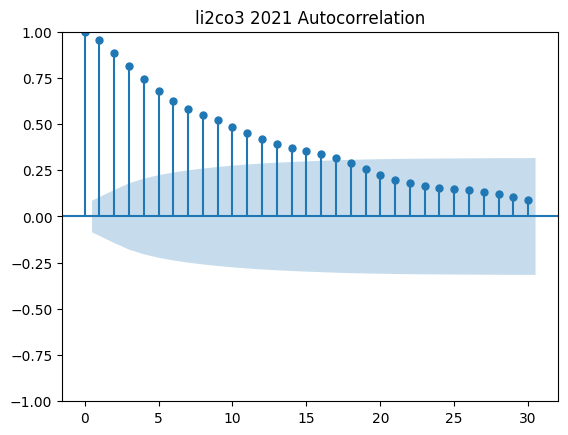

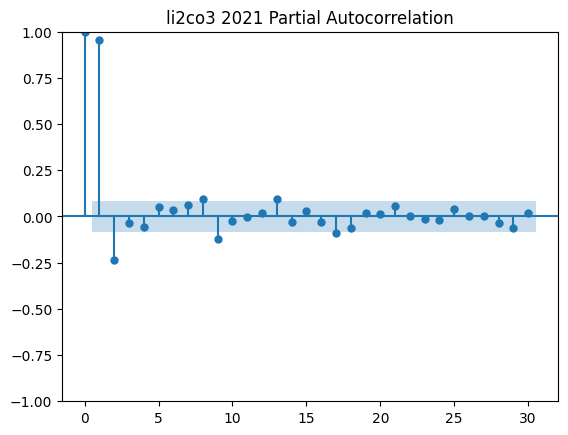

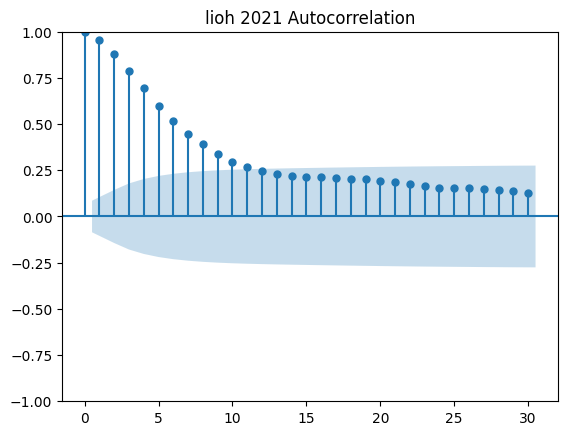

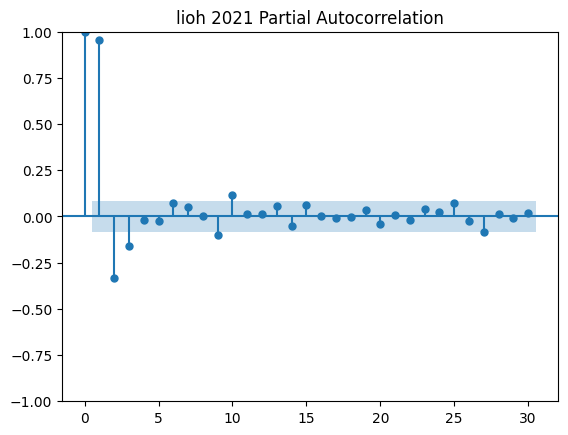

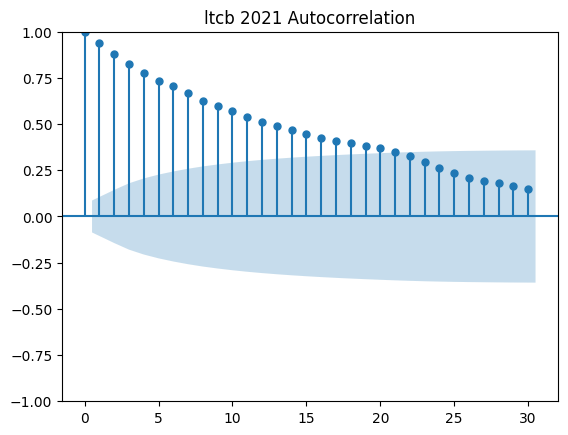

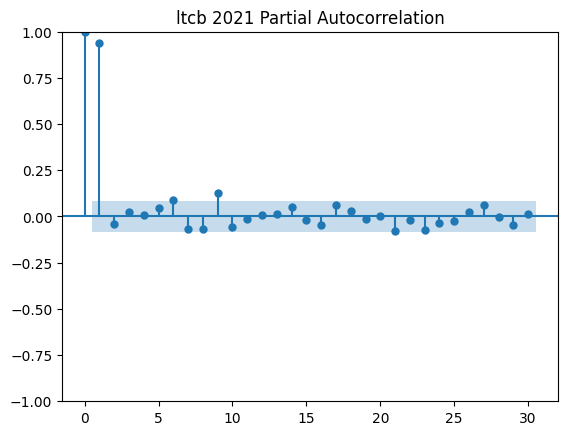

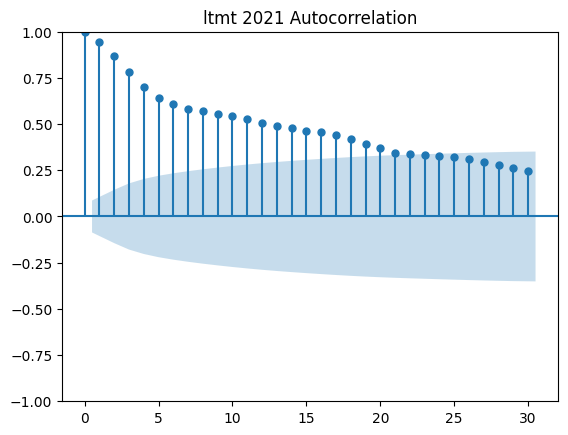

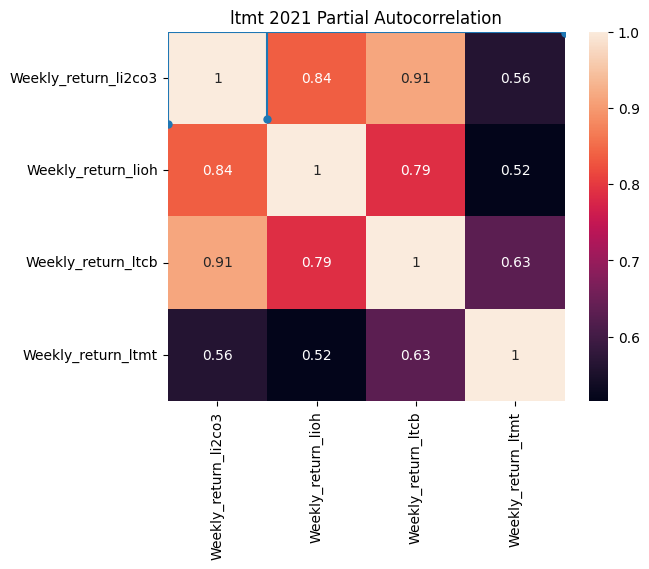

In [8]:
y_2021 = {
    'li2co3': set_period(wind_process(pd.read_csv('./Data/Lithium Carbonate (wind database).csv')),'2021-01-01'), 
    'lioh': set_period(wind_process(pd.read_csv('./Data/Lithium Hydroxide (wind database).csv')),'2021-01-01'), 
    'ltcb': set_period(investing_process(pd.read_csv('./Data/99C-LTCB.csv', usecols=[0,1])),'2021-01-01'), 
    'ltmt': set_period(investing_process(pd.read_csv('./Data/99MIN-LTMT.csv', usecols=[0,1])),'2021-01-01')
}

y_2021_merged = pd.DataFrame()

for df in y_2021:
    y_2021[df]['Prior_date'] = y_2021[df].index - datetime.timedelta(days=7) # Get date one week ago
    y_2021[df]['Prior_price'] = y_2021[df]['Prior_date'].apply(lambda i: y_2021[df].loc[i,'Price'] if i in y_2021[df].index else np.NaN) # Get price one week ago
     
    y_2021[df]['Weekly_return'] = np.log(y_2021[df]['Price']) - np.log(y_2021[df]['Prior_price']) # Weekly return
    y_2021[df]['Weekly_return'].replace([np.inf, -np.inf], np.NaN, inplace = True)
    y_2021[df] = y_2021[df].drop(columns = ['Prior_date','Prior_price'])

    # plt.figure(figsize = (10,6))
    # plt.plot(y_2021[df].index, y_2021[df]['Weekly_return'],label = yn[df])
    # plt.title(f'{df} Weekly Return')
    # plt.tick_params(axis='x',labelrotation=45)

    y_2021_merged = pd.merge(y_2021_merged, y_2021[df].loc[:,'Weekly_return'], how='right', left_index=True, right_index=True, suffixes=(None,f'_{df}'))
    
    y_2021[df] = y_2021[df].dropna(axis = 0)
    acf = plot_acf(y_2021[df]['Weekly_return'], lags = 30, alpha = 0.05, title = f'{df} 2021 Autocorrelation')
    pacf = plot_pacf(y_2021[df]['Weekly_return'], lags = 30, alpha = 0.05, method = 'ywm', title = f'{df} 2021 Partial Autocorrelation')

y_2021_merged.rename(columns = {'Weekly_return':'Weekly_return_li2co3'}, inplace=True)
display(y_2021_merged)
sns.heatmap(y_2021_merged.corr(),annot=True)